# 1.Import Libraries

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc
from sklearn.cluster import KMeans

# 2.Prepare the Data

## 2.1 Read The Data

In [167]:
Health = pd.read_csv(r'heart_attack_dataset.csv')


## 2.2 View Sample of Data

In [168]:
Health.head()

,Gender,Age,Blood Pressure (mmHg),Cholesterol (mg/dL),Has Diabetes,Smoking Status,Chest Pain Type,Treatment
0,Male,70,181,262,No,Never,Typical Angina,Lifestyle Changes
1,Female,55,103,253,Yes,Never,Atypical Angina,Angioplasty
2,Male,42,95,295,Yes,Current,Typical Angina,Angioplasty
3,Male,84,106,270,No,Never,Atypical Angina,Coronary Artery Bypass Graft (CABG)
4,Male,86,187,296,Yes,Current,Non-anginal Pain,Medication


## 2.3 Check Nulls

In [169]:
print(Health.isnull().sum())

Gender                   0
Age                      0
Blood Pressure (mmHg)    0
Cholesterol (mg/dL)      0
Has Diabetes             0
Smoking Status           0
Chest Pain Type          0
Treatment                0
dtype: int64


## 2.4 Discribe the Data

In [170]:
Health.describe()

,Age,Blood Pressure (mmHg),Cholesterol (mg/dL)
count,1000.000000,1000.000000,1000.000000
mean,60.338000,145.440000,223.789000
std,17.317496,31.756525,42.787817
min,30.000000,90.000000,150.000000
25%,45.000000,118.000000,185.000000
50%,60.500000,146.000000,225.500000
75%,76.000000,173.000000,259.000000
max,89.000000,199.000000,299.000000


In [171]:
Health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Gender                 1000 non-null   object
 1   Age                    1000 non-null   int64 
 2   Blood Pressure (mmHg)  1000 non-null   int64 
 3   Cholesterol (mg/dL)    1000 non-null   int64 
 4   Has Diabetes           1000 non-null   object
 5   Smoking Status         1000 non-null   object
 6   Chest Pain Type        1000 non-null   object
 7   Treatment              1000 non-null   object
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


# 3 visualization

## 3.1 Plot Age Distribution

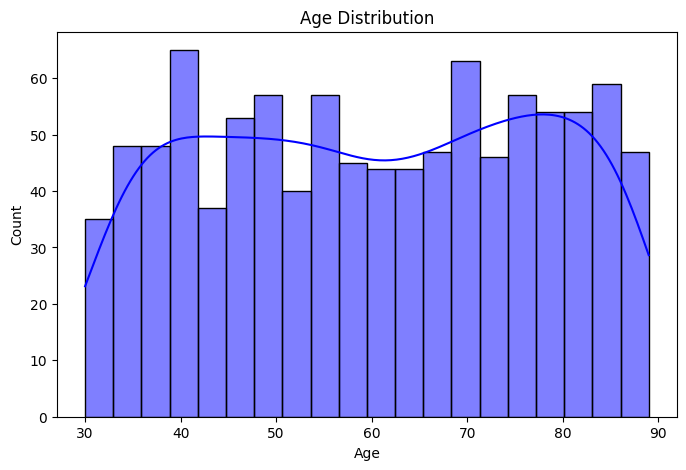

In [172]:
plt.figure(figsize=(8, 5))
sns.histplot(Health['Age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

## 3.2 Plot Gender Distribution

<ipython-input-173-057e05188532>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=Health, palette='coolwarm')


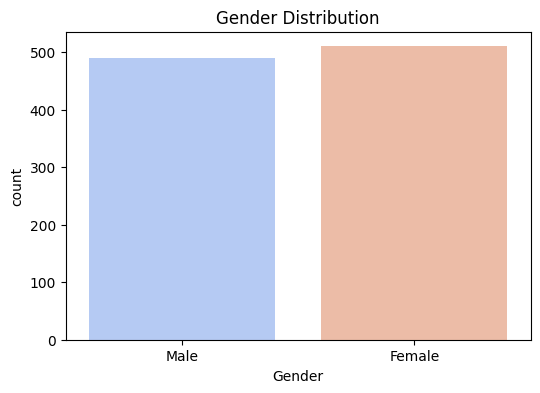

In [173]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=Health, palette='coolwarm')
plt.title('Gender Distribution')
plt.show()

## 3.3 Plot Smoking Status

<ipython-input-174-00244a42a919>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Smoking Status', data=Health, palette='Set2')


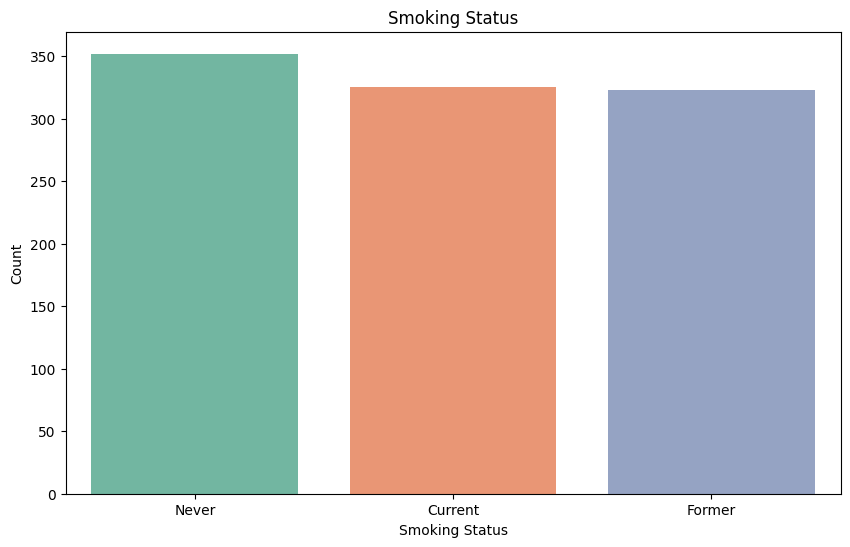

In [174]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Smoking Status', data=Health, palette='Set2')
plt.title('Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

## 3.3 Plot Chest Pain Type

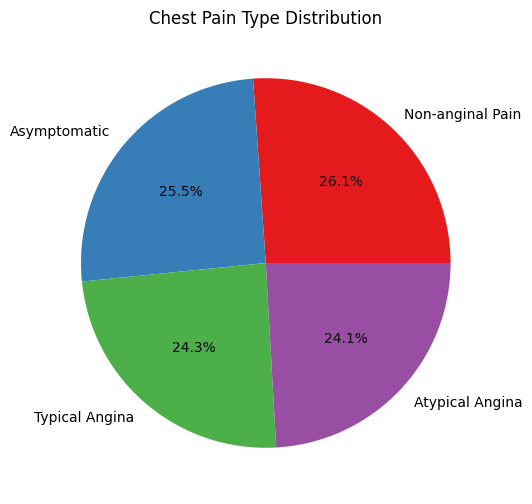

In [175]:
plt.figure(figsize=(10, 6))
Health['Chest Pain Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set1'))
plt.title('Chest Pain Type Distribution')
plt.ylabel('')
plt.show()

## 3.4 plot The Treatment

<ipython-input-176-980e74f676dc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Treatment', data=Health, palette='husl')


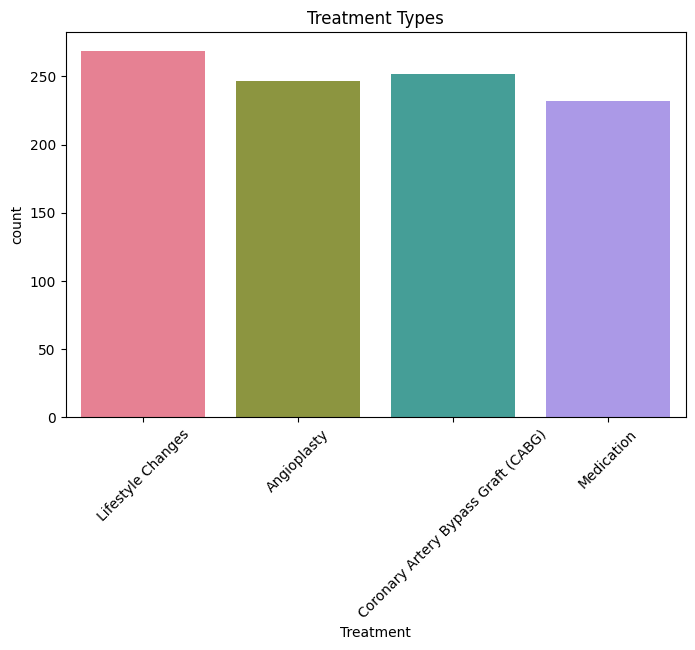

In [176]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Treatment', data=Health, palette='husl')
plt.title('Treatment Types')
plt.xticks(rotation=45)
plt.show()

## 3.5 Plot Blood Pressure due to Has Diabetes

<ipython-input-177-95c21f00cd3b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Has Diabetes', y='Blood Pressure (mmHg)', data=Health, palette='coolwarm')


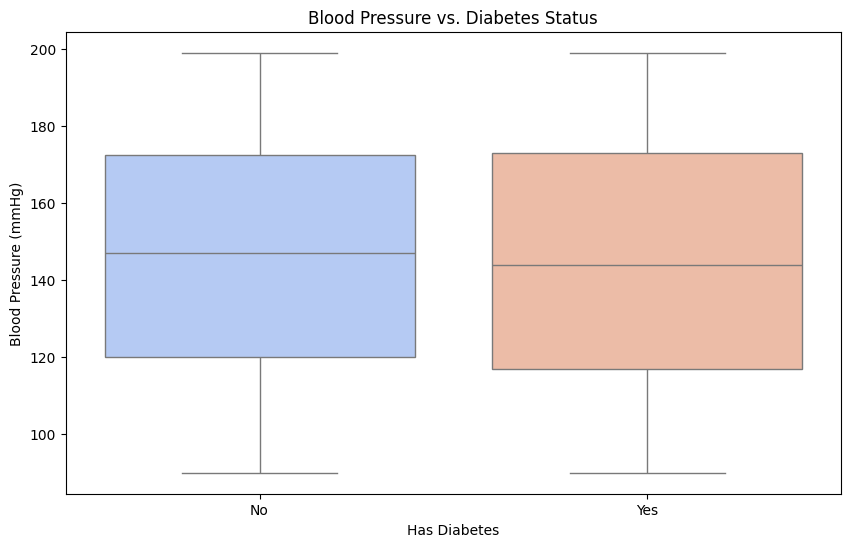

In [177]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Has Diabetes', y='Blood Pressure (mmHg)', data=Health, palette='coolwarm')
plt.title('Blood Pressure vs. Diabetes Status')
plt.show()


## 3.6 Create binary gender feature

In [178]:
Health['is_male'] = Health['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

## 3.7 Ordinal encoding for smoking status


In [179]:
smoking_order = {'Never': 0, 'Former': 1, 'Current': 2}
Health['smoking_encoded'] = Health['Smoking Status'].map(smoking_order)

## 3.8 Creating age groups


In [180]:
bins = [0, 40, 60, 100]
labels = ['young', 'middle', 'senior']
Health['age_group'] = pd.cut(Health['Age'], bins=bins, labels=labels)

## 3.9 Creating blood pressure catagories

In [181]:
def bp_category(systolic):
    if systolic < 120: return 'normal'
    elif 120 <= systolic < 130: return 'elevated'
    elif 130 <= systolic < 140: return 'stage1'
    else: return 'stage2'

Health['bp_category'] = Health['Blood Pressure (mmHg)'].apply(bp_category)


## 4.0 Creating Cholesterol categories

In [182]:
def chol_category(chol):
    if chol < 200: return 'normal'
    elif 200 <= chol < 240: return 'borderline'
    else: return 'high'

Health['chol_category'] = Health['Cholesterol (mg/dL)'].apply(chol_category)

## 4.1 Age-Cholesterol interaction


In [183]:
Health['age_chol_interaction'] = Health['Age'] * Health['Cholesterol (mg/dL)']

## 4.2 BP-Diabetes interaction


In [184]:
Health['bp_diabetes_interaction'] = Health['Blood Pressure (mmHg)'] * Health['Has Diabetes'].apply(lambda x: 1 if x == 'Yes' else 0)

## 4.3 Risk Score :(

In [185]:
Health['risk_score'] = (Health['Age']/10) + (Health['Blood Pressure (mmHg)']/100) + (Health['Cholesterol (mg/dL)']/200) + \
                   Health['Has Diabetes'].apply(lambda x: 1 if x == 'Yes' else 0) + \
                   Health['smoking_encoded']

## 4.4 Grouping similar patients

In [186]:
cluster_features = ['Age', 'Blood Pressure (mmHg)', 'Cholesterol (mg/dL)']
kmeans = KMeans(n_clusters=3)
Health['patient_cluster'] = kmeans.fit_predict(Health[cluster_features])

## Prepare Machine Learning

In [187]:
features_to_keep = [
    'Age',
    'Blood Pressure (mmHg)',
    'Cholesterol (mg/dL)',
    'is_male',
    'Has Diabetes',
    'smoking_encoded',
    'age_chol_interaction',
    'bp_diabetes_interaction',
    'risk_score',
    'age_group',
    'bp_category',
    'chol_category',
    'Chest Pain Type',
    'Treatment'
]

Health = Health[features_to_keep]

## Processing

In [188]:
# Separate features and target
X = Health.drop('Treatment', axis=1)
y = Health['Treatment']

# features
categorical_features = ['Has Diabetes', 'age_group', 'bp_category', 'chol_category', 'Chest Pain Type']
numerical_features = ['Age', 'Blood Pressure (mmHg)', 'Cholesterol (mg/dL)',
                     'is_male', 'smoking_encoded', 'age_chol_interaction',
                     'bp_diabetes_interaction', 'risk_score']

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [189]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numerical_features + list(cat_features)

# Create processed DataFrame
df_processed = pd.read_csv('heart_attack_processed.csv')

# Features and Target
X = df_processed.drop(columns=['Treatment'])
y = df_processed['Treatment']

## Save the processed Data

In [190]:
df_processed.to_csv('heart_attack_processed.csv', index=False)

# Handling Missing Values

In [191]:
Health.fillna(Health.select_dtypes(include=['number']).mean(), inplace=True)

# Encoding Categorical Data with OneHotEncoder

In [192]:
categorical_columns = ['Has Diabetes', 'age_group', 'bp_category', 'chol_category', 'Chest Pain Type']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(Health[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

In [193]:
Health = pd.concat([Health.drop(columns=categorical_columns), encoded_df], axis=1)

## Defining Features and Target

In [194]:
X = Health.drop(columns=['Treatment'])
y = Health['Treatment']


## Splitting Data into Training and Test Sets

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Optimization with GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

## Best Model After GridSearch

In [198]:
best_model = grid_search.best_estimator_
print("أفضل معاملات للنموذج:", grid_search.best_params_)

أفضل معاملات للنموذج: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


## Training the Best Model

In [199]:
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

## Model Evaluation

In [200]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Model Accuracy: 0.255
                                     precision    recall  f1-score   support

                        Angioplasty       0.19      0.21      0.20        48
Coronary Artery Bypass Graft (CABG)       0.22      0.28      0.25        47
                  Lifestyle Changes       0.29      0.33      0.31        52
                         Medication       0.37      0.21      0.27        53

                           accuracy                           0.26       200
                          macro avg       0.27      0.25      0.25       200
                       weighted avg       0.27      0.26      0.26       200



# Evaluation By Confusion Matrix

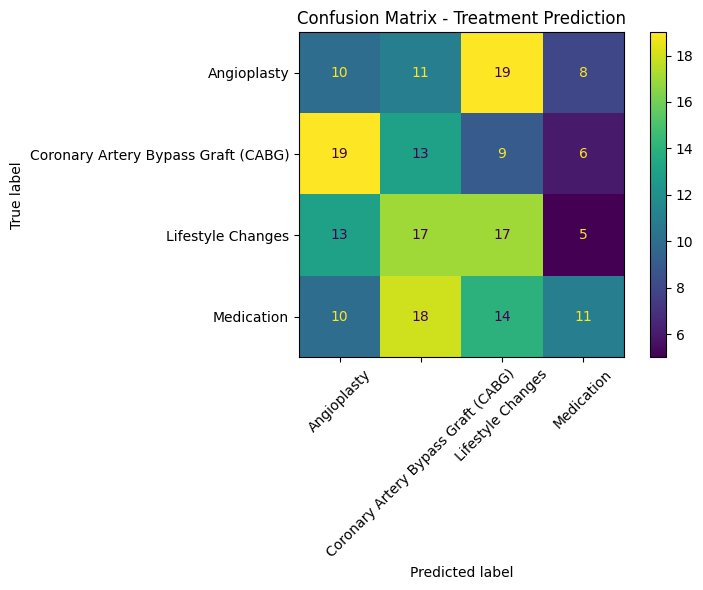

In [201]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - Treatment Prediction")
plt.tight_layout()
plt.show()

## Feature Importance Analysis

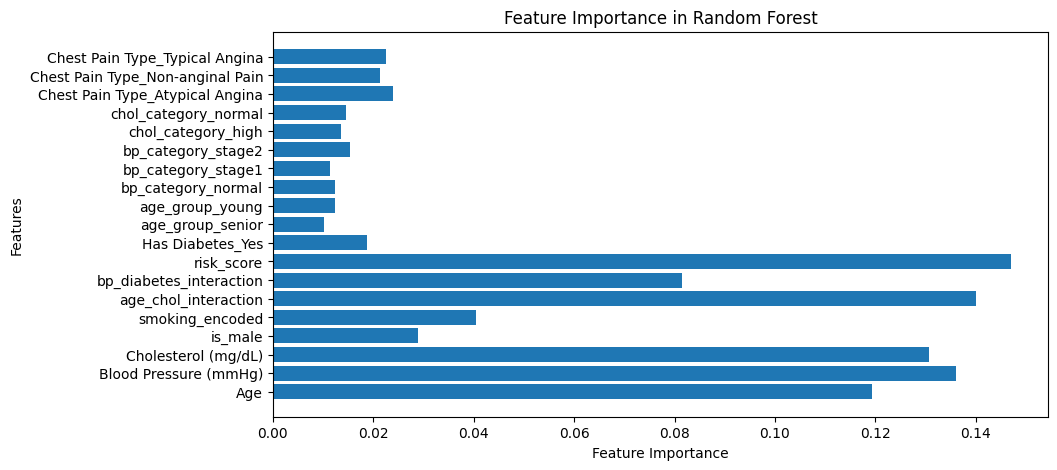

In [202]:
feature_importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 5))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

## ROC Curve Plot

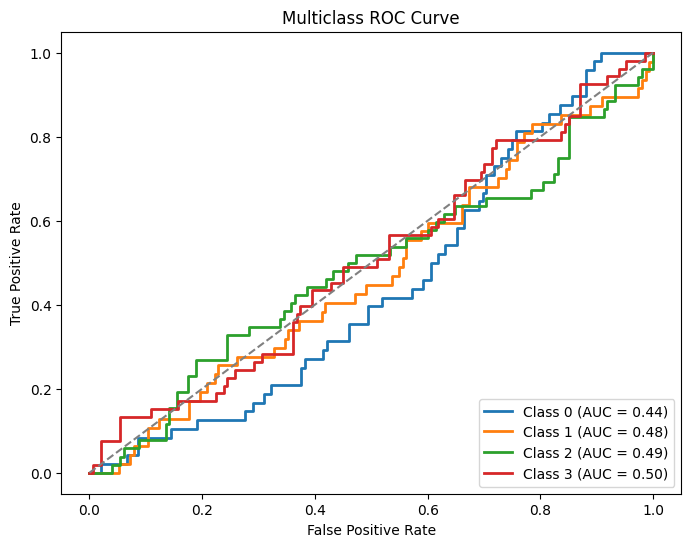

In [205]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
best_model = OneVsRestClassifier(best_model)
best_model.fit(X_train, y_train)
y_prob = best_model.predict_proba(X_test)
plt.figure(figsize=(8, 6))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()
